In [1]:
import os
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import random
import tensorflow as tf
from transformers import AutoTokenizer
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, confusion_matrix , accuracy_score , classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.utils import shuffle
import platform
from tensorflow.keras.models import Sequential, Model
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from tensorflow.keras.layers import Dense, Embedding, Conv1D, LSTM, Reshape, AveragePooling1D, GlobalMaxPooling1D, Input, MaxPooling1D, Dropout, Flatten,concatenate
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import backend as K
from keras import regularizers
seed=2023

In [2]:
print(platform.python_version())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

3.9.12
Num GPUs Available:  1


In [3]:
df0 = pd.read_csv("E:/CNSI_project/demo_and_data_5.0/Processed_data/MIMIC/aim2_dataAll_filtered_NameShorted.csv")
df0

,subject_id,hadm_id,chartdate,B_Albumin,B_AlkalinePhosphatase,B_Calcium,B_Chloride,B_LactateDehydrogenase,B_Phosphate,B_UreaNitrogen,...,age,resprate,acuity,Chief Complaint,icd_title,History of Present Illness,Past Medical History,Allergies,Family History,hospital_expire_flag
0,10001217,24597018,2157/11/19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,55,16.0,3.0,"LEFT HAND PAINS, Left hand and face numbness, ...",Cerebral edema; Compression of brain; Family h...,Mrs. ___ is a ___ y/o F from ___ with history ...,Multiple sclerosis,Penicillins,"Mother with pancreatic cancer, brother-lung ca...",0
1,10003019,21616816,2174/9/18,2.6,NaN,10.4,102.0,NaN,2.8,32.0,...,72,16.0,2.0,"FEVER/MS CHANGES, confusion, rehab placement","Acute kidney failure, unspecified; Asthma, uns...","___ male w/ PMH of sarcoidosis, sleep apnea, n...","1. Sarcoidosis, dx skin bx:intestinal & pulmon...",Oxycodone / Ragweed,"Mother:___, cardiac disease. Father:diverticul...",0
2,10005808,26543907,2119/1/2,NaN,48.0,9.3,105.0,NaN,2.5,18.0,...,53,NaN,NaN,limb weakness and tingling,Acute infective polyneuritis,Mr. ___ is a ___ year old right handed gentlem...,Hiatal hernia in ___ Occasional heartburn,No Known Allergies / Adverse Drug Reactions,He has no family history of autoimmune disease...,0
3,10006269,27357430,2124/6/26,4.9,80.0,NaN,95.0,NaN,NaN,15.0,...,51,19.0,3.0,"Fever, Headache",Duodenitis without bleeding; Essential (primar...,NaN,NaN,No Known Allergies / Adverse Drug Reactions,NaN,0
4,10014078,25809882,2166/8/22,NaN,NaN,8.1,117.0,NaN,2.8,7.0,...,60,NaN,NaN,seizure,Benign neoplasm of cerebral meninges; Diabetes...,The pt is a ___ year-old woman who presents as...,hx of atypical meningioma - grade 2 - resected...,No Known Allergies / Adverse Drug Reactions,noncontributory,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5790,19994772,29219051,2181/4/18,NaN,NaN,NaN,103.0,150.0,NaN,9.0,...,55,20.0,2.0,Aletered mental status and fever,Abnormal involuntary movements; Candidiasis of...,___ is a ___ woman with,PAST MEDICAL HISTORY:Recurrent glioblastoma in...,Keflex,Non-contributory.,0
5791,19994772,29606061,2180/12/18,NaN,NaN,9.7,103.0,NaN,3.3,16.0,...,54,NaN,NaN,Recurrent glioblastoma.,"Cerebral aneurysm, nonruptured; Compression of...",Ms. ___ is a ___ y/o F s/p resection of gliobl...,Hyperlipidemia,___,non-contributory,0
5792,19995080,23057109,2147/7/13,2.3,961.0,7.5,105.0,NaN,2.3,17.0,...,59,NaN,NaN,Confusion- Altered Mental Status- transfer fro...,Calculus of gallbladder and bile duct without ...,___ M with AIDS and med non-compliance (CD4 20...,"- AIDS off ART prescribed for Truvada T qd, Ka...",Penicillins,Father died of AD at age ___. Mother died of D...,0
5793,19999784,24935234,2119/7/7,4.3,NaN,NaN,NaN,102.0,NaN,NaN,...,57,16.0,2.0,"Abnormal MRI, weakness",Abnormal cytological findings in cerebrospinal...,Mr. ___ is a ___ without significant medical h...,PAST ONCOLOGIC HISTORY:___ is a ___ right-hand...,No Known Allergies / Adverse Drug Reactions,Father had prostate cancer. Denies otherwise ...,0


In [5]:
df0.hospital_expire_flag.value_counts()

0    5500
1     295
Name: hospital_expire_flag, dtype: int64

In [6]:
########### dataset 1 ########
df1 = df0.copy()
df1 = df1[["Chief Complaint","hospital_expire_flag"]]
df2 = df1.applymap(lambda x: x.lower() if isinstance(x, str) else x)
# df2 = df2[df2['hospital_expire_flag'].notnull()]
# df2 = df2.dropna(thresh=2,axis=0)   # without even one Nan value
df2['hospital_expire_flag'] = df2['hospital_expire_flag'].astype(np.int16)
df2.rename(columns={'Chief Complaint':'English'},inplace=True)
df2

,English,hospital_expire_flag
0,"left hand pains, left hand and face numbness, ...",0
1,"fever/ms changes, confusion, rehab placement",0
2,limb weakness and tingling,0
3,"fever, headache",0
4,seizure,0
...,...,...
5790,aletered mental status and fever,0
5791,recurrent glioblastoma.,0
5792,confusion- altered mental status- transfer fro...,0
5793,"abnormal mri, weakness",0


In [7]:
df_train_chief, df_test_chief = train_test_split(df2, test_size=0.2, random_state=seed, stratify=df2['hospital_expire_flag'])
df_train_chief

,English,hospital_expire_flag
918,"headache, n/v",0
1754,"overdose, requesting detoxification",0
3831,cerebellar hemorrhage,0
3261,s/p fall ~ 30 feet,0
1543,"headache, fevers and ha",0
...,...,...
5589,overnight numbness and paralysis from sternum ...,0
3700,"seizure, transfer, agitation, seizure",0
2647,"hypotension, weakness, fatigue, lightheadednes...",0
4068,"headache, facial droop, episode of emotional l...",0


In [8]:
df_train_chief.hospital_expire_flag.value_counts()

0    4400
1     236
Name: hospital_expire_flag, dtype: int64

In [9]:
df_test_chief.hospital_expire_flag.value_counts()

0    1100
1      59
Name: hospital_expire_flag, dtype: int64

In [11]:
########### dataset 2 ########
# loading structured data
# df_temp = pd.read_csv("E:/CNSI_project/demo_and_data_5.0/Processed_data/MIMIC/aim2_LASSOed.csv")
# df3 = df0[df_temp.columns]
m = df0.iloc[:,3:-7].columns.tolist()
m.append("hospital_expire_flag")
df3 = df0[m]
df3 = df3.loc[df2.index]   # 保持和df2相同的行
df33 = df3.copy()
df3 = df3.drop(['hospital_expire_flag'],axis=1)
# 空值填充
from sklearn.impute import KNNImputer
import pickle
imputer = KNNImputer(n_neighbors=5, weights='distance')
df_temp = imputer.fit_transform(df3)
df3 = pd.DataFrame(df_temp, columns=df3.columns.tolist(), index=df3.index)

df3['hospital_expire_flag'] = df2['hospital_expire_flag']

df_train_structured, df_test_structured = train_test_split(df3, test_size=0.2, random_state=seed, stratify=df3['hospital_expire_flag'])
df_train_structured

,B_Albumin,B_AlkalinePhosphatase,B_Calcium,B_Chloride,B_LactateDehydrogenase,B_Phosphate,B_UreaNitrogen,B_Eosinophils,B_INR(PT),B_MCV,...,B_WhiteBloodCells,C_LactateDehydrogenase,C_Protein,C_Eosinophils,C_Polys,C_RBC,age,resprate,acuity,hospital_expire_flag
918,3.989167,97.950659,8.600000,105.000000,358.358425,4.000000,18.0,5.334871,1.233333,84.666667,...,7.9,15.000000,65.0,2.231370,0.0,0.0,54.0,18.000000,2.000000,0
1754,3.800000,88.000000,8.600000,107.000000,282.000000,2.300000,6.0,2.174196,1.000000,89.000000,...,16.2,56.526572,40.0,1.361854,47.0,725.0,54.0,12.000000,2.000000,0
3831,3.600686,74.212573,9.300000,95.000000,279.002884,3.200000,14.0,1.840613,1.100000,80.000000,...,3.6,66.769096,37.0,3.010910,60.0,6800.0,74.0,21.028621,1.621295,0
3261,2.700000,89.121936,7.900000,104.000000,511.000000,3.000000,14.0,0.534978,1.100000,85.000000,...,10.3,89.019580,43.0,1.000000,94.0,1220.0,40.0,18.349861,2.211346,0
1543,3.500000,147.000000,8.653562,104.000000,234.808411,2.977631,9.0,1.000000,1.000000,91.000000,...,2.6,25.313947,29.0,3.428071,0.0,106.0,47.0,18.000000,3.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5589,2.100000,60.000000,8.200000,108.000000,224.000000,3.600000,8.0,2.055769,1.300000,92.000000,...,6.0,18.512892,27.0,1.218353,0.0,3.0,62.0,19.293465,2.397178,0
3700,3.800000,74.000000,8.900000,106.000000,285.099465,3.900000,14.0,0.100000,1.500000,96.000000,...,13.8,39.807361,51.0,1.664300,38.0,469.0,68.0,26.000000,2.000000,0
2647,3.763607,85.388820,9.000000,109.000000,286.582929,2.300000,8.0,1.000000,1.236761,90.000000,...,58.2,21.260439,44.0,2.182744,24.0,160.0,61.0,18.000000,1.000000,0
4068,4.215145,76.427360,9.965113,102.558463,183.195525,4.127534,20.0,1.600000,1.100000,90.000000,...,3.9,14.807330,22.0,5.628828,0.0,1.0,64.0,20.000000,3.000000,0


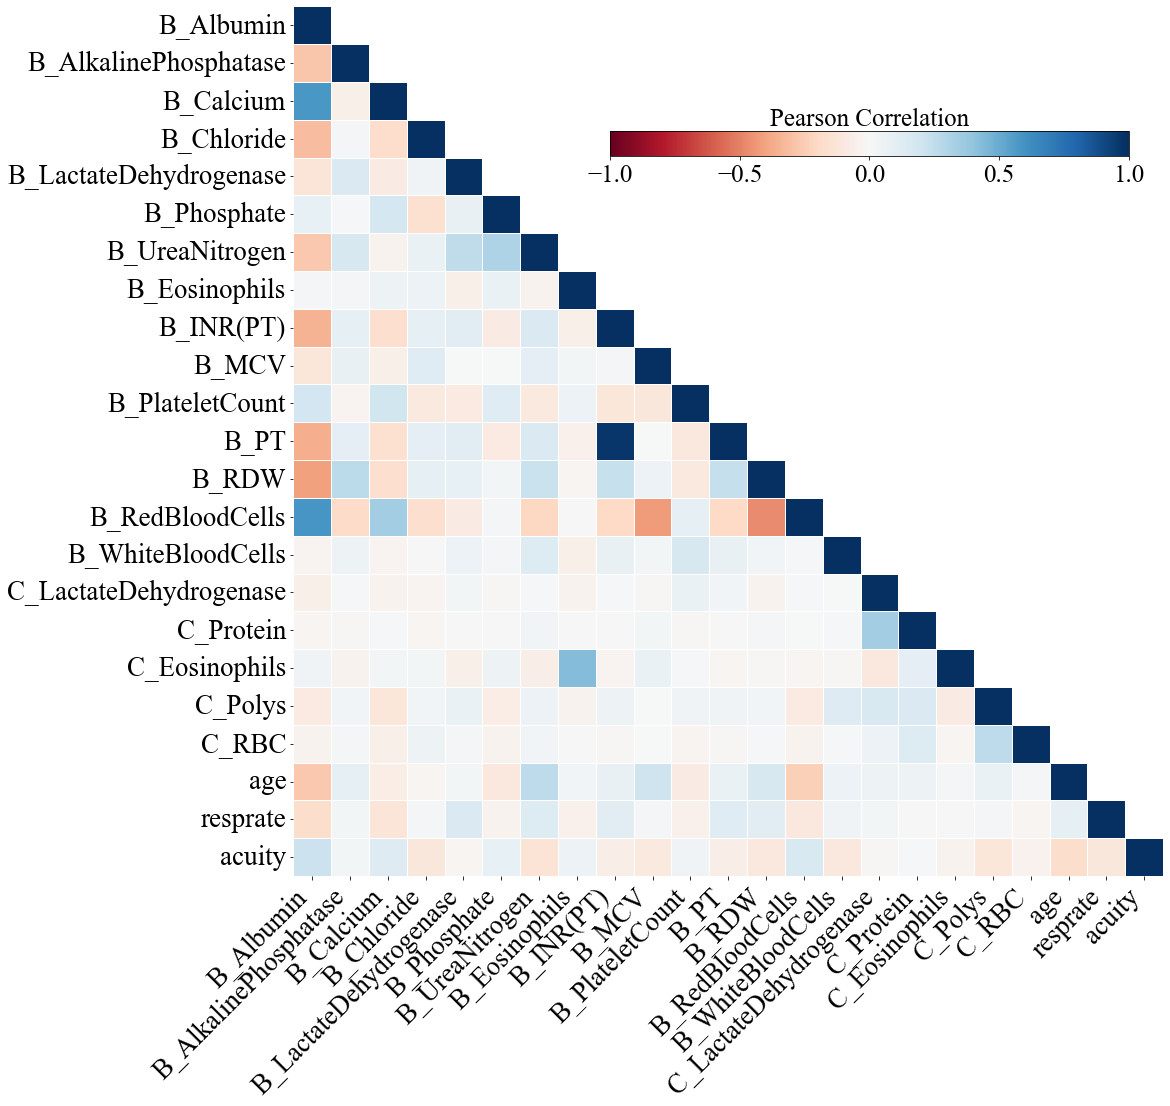

In [12]:
# generate correlation matrix of the numerical variables 
df_input1 = df33.drop(['hospital_expire_flag'], axis=1)
#correlation
correlation = df_input1.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array  = np.array(correlation)

# 这个cell和上一个cell只能保留一个
FullNamesList = correlation.columns.tolist()
#convert to array
corr_array  = np.array(correlation)

# from pylab import mpl
import matplotlib as mpl
# mpl.rcParams['font.family'] = 'sans-serif'
# mpl.rcParams['font.sans-serif'] = 'NSimSun,Times New Roman'
mpl.rcParams['font.sans-serif'] = 'Times New Roman'
font = {'family': 'Times New Roman',
            'color': 'k',
            'weight': 'normal',
            'size': 25,}

# 绘下三角
mask = np.ones_like(corr_array, dtype=np.bool_)   # 调整zeros_like/ones_liks和下面mask的True或False一起控制上三角或下三角
mask[np.tril_indices_from(mask)] = False

fig = plt.figure(figsize=(16,16))
ax = sns.heatmap(data=corr_array, 
            cmap='RdBu',
            square=True,
            mask = mask,
            linewidths=1,
            linecolor="white",
#             annot=array_new,
            fmt='',            # 若填充的为字符，则需要这个语句
            annot_kws={"size":25},    # 填充字符的大小
            xticklabels=FullNamesList,
            yticklabels=FullNamesList,
            vmin=-1, vmax=1,  # 设置颜色条的范围为-1到1
            cbar=False,
#             cbar_kws={"shrink": 0.6, "location":'top', "use_gridspec":False},
           )
plt.xticks([i + 0.5 for i in range(len(FullNamesList))], FullNamesList, rotation = 45, fontsize=27, ha='right', fontname="Times New Roman")  # ha为文字的旋转中心
plt.yticks([i + 0.5 for i in range(len(FullNamesList))], FullNamesList, rotation = 0, fontsize=27, ha='right')

# 方法1 传统colorbar设置，需要配合sns.heatmap中的cbar_kws和cbar参数一起设置。
# cbar = ax.collections[0].colorbar
# cbar.ax.tick_params(labelsize=20)
# cbar.set_label(r'Pearson Correlation',fontdict=font)

# 方法2 自定义colorbar的位置
position = fig.add_axes([0.41, 0.75, 0.45, 0.022]) #  [距离左边距离，距离下面距离，bar的长度，bar的宽度]
cbar1 = plt.colorbar(ax.collections[0], cax=position, orientation='horizontal', )
cbar1.ax.tick_params(labelsize=25)
# cbar1.set_label(r'Pearson Correlation1',fontdict=font, loc='center')  # 文字默认在bar的下面
cbar1.ax.set_title(r'Pearson Correlation',fontdict=font)   # 文字在bar的上面

path = os.path.join("E:/CNSI_project/demo_and_data_5.0/figure_in_paper/aim2", "corr.tif")
plt.savefig(path, dpi=300, bbox_inches='tight')

# 保存高清图像
# plt.savefig('./Processed_data/MIMIC/TrainingSet/image1/Correlation_Matrix0.svg', dpi=300, bbox_inches='tight')
# plt.tight_layout()   # 加上此句可能会导致图像错位。

plt.show()

In [13]:
########### dataset 3 ########
df4 = df0.copy()
df4 = df4[["icd_title","hospital_expire_flag"]]
df4 = df4.applymap(lambda x: x.lower() if isinstance(x, str) else x)
df4 = df4.loc[df2.index]   # 保持和df2相同的行
df4['hospital_expire_flag'] = df4['hospital_expire_flag'].astype(np.int16)
df4.rename(columns={'icd_title':'English'},inplace=True)

df_train_icd, df_test_icd = train_test_split(df4, test_size=0.2, random_state=seed, stratify=df4['hospital_expire_flag'])
df_train_icd

,English,hospital_expire_flag
918,"atypical chronic myeloid leukemia, bcr/abl-neg...",0
1754,acute respiratory failure with hypoxia; alcoho...,0
3831,acute respiratory failure; atrial fibrillation...,0
3261,accidental fall from ladder; accidents occurri...,0
1543,"anemia, unspecified; headache; leukocytopenia,...",0
...,...,...
5589,"asthma, unspecified type, unspecified; depress...",0
3700,adverse effect of antiallergic and antiemetic ...,0
2647,acidosis; acute posthemorrhagic anemia; acute ...,0
4068,arteriovenous malformation of cerebral vessels...,0


In [14]:
########### dataset 4 ########
df5 = df0.copy()
df5 = df5[["History of Present Illness","hospital_expire_flag"]]
df5 = df5.applymap(lambda x: x.lower() if isinstance(x, str) else x)
df5 = df5.loc[df2.index]   # 保持和df2相同的行
df5['hospital_expire_flag'] = df5['hospital_expire_flag'].astype(np.int16)
df5.rename(columns={'History of Present Illness':'English'},inplace=True)

df_train_ill, df_test_ill = train_test_split(df5, test_size=0.2, random_state=seed, stratify=df5['hospital_expire_flag'])
df_train_ill

,English,hospital_expire_flag
918,"___ with pituitary tumor, cml presented to ed ...",0
1754,___ male unknown,0
3831,patient is a ___ yo female with a pmh of perip...,0
3261,___ year old male ___ speaking s/p fall ~30 fe...,0
1543,___ yo female with history of crohn's on azath...,0
...,...,...
5589,___ is a ___ year old right handed woman who p...,0
3700,"mr. ___ is a ___ man with htn, extensive psych...",0
2647,ms. ___ is a ___ year-old lady with recent pro...,0
4068,hpi:ms. ___ is a ___ year old female with hist...,0


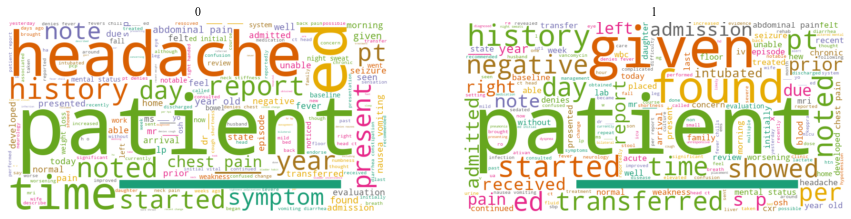

In [15]:
data = df5.copy()

# Group the data by label and concatenate the text data for each group
groups = data.groupby('hospital_expire_flag')['English'].apply(lambda x: ' '.join(str(i) for i in x))

# Generate a word cloud for each group
wordclouds = []
for group_name, group_data in groups.items():   # groups.items(): output keys and values in same time.
    # Create a word cloud object and generate the word cloud
    wc = WordCloud(width=800, height=400, background_color='white', colormap='Dark2',random_state=2023).generate(group_data)
    wordclouds.append((group_name, wc))

# Plot the word clouds
fig, axs = plt.subplots(1, len(wordclouds), figsize=(15, 10))
for i, (group_name, wc) in enumerate(wordclouds):
    axs[i].imshow(wc, interpolation='bilinear')
    axs[i].set_title(group_name)
    axs[i].axis('off')

plt.show()

In [16]:
########### dataset 5 ########
df6 = df0.copy()
df6 = df6[["Past Medical History","hospital_expire_flag"]]
df6 = df6.applymap(lambda x: x.lower() if isinstance(x, str) else x)
df6 = df6.loc[df2.index]   # 保持和df2相同的行
df6['hospital_expire_flag'] = df6['hospital_expire_flag'].astype(np.int16)
df6.rename(columns={'Past Medical History':'English'},inplace=True)

df_train_medical, df_test_medical = train_test_split(df6, test_size=0.2, random_state=seed, stratify=df6['hospital_expire_flag'])
df_train_medical

,English,hospital_expire_flag
918,- chronic phase cml (dx'd ___ bcr-abl negative...,0
1754,htn substance abuse/dependence schizoaffective...,0
3831,"- peripheral vascular disease, recent stent to...",0
3261,none,0
1543,"-crohn's disease, since her teens, on azathiop...",0
...,...,...
5589,-mitral valve prolapse -hypertension -asthma -...,0
3700,htn h/o psychosis h/o rhabdomyolysis (prior ad...,0
2647,"past oncologic history (per omr, reviewed):- _...",0
4068,"hemorrhage secondary avm, occurred ___ years a...",0


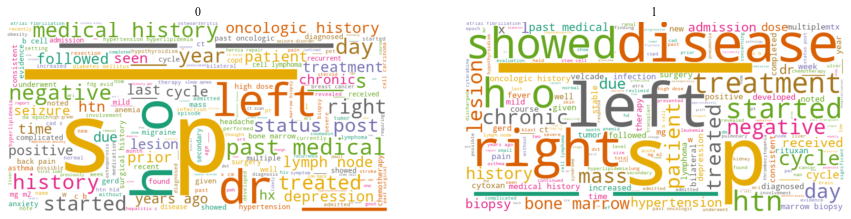

In [17]:
data = df6.copy()

# Group the data by label and concatenate the text data for each group
groups = data.groupby('hospital_expire_flag')['English'].apply(lambda x: ' '.join(str(i) for i in x))

# Generate a word cloud for each group
wordclouds = []
for group_name, group_data in groups.items():   # groups.items(): output keys and values in same time.
    # Create a word cloud object and generate the word cloud
    wc = WordCloud(width=800, height=400, background_color='white', colormap='Dark2',random_state=2023).generate(group_data)
    wordclouds.append((group_name, wc))

# Plot the word clouds
fig, axs = plt.subplots(1, len(wordclouds), figsize=(15, 10))
for i, (group_name, wc) in enumerate(wordclouds):
    axs[i].imshow(wc, interpolation='bilinear')
    axs[i].set_title(group_name)
    axs[i].axis('off')

plt.show()

In [18]:
########### dataset 6 ########
df7 = df0.copy()
df7 = df7[["Allergies","hospital_expire_flag"]]
df7 = df7.applymap(lambda x: x.lower() if isinstance(x, str) else x)
df7 = df7.loc[df2.index]   # 保持和df2相同的行
df7['hospital_expire_flag'] = df7['hospital_expire_flag'].astype(np.int16)
df7.rename(columns={'Allergies':'English'},inplace=True)

df_train_Allergies, df_test_Allergies = train_test_split(df7, test_size=0.2, random_state=seed, stratify=df7['hospital_expire_flag'])
df_train_Allergies

,English,hospital_expire_flag
918,no known allergies / adverse drug reactions,0
1754,no known allergies / adverse drug reactions,0
3831,levofloxacin,0
3261,patient recorded as having no known allergies ...,0
1543,methotrexate / remicade,0
...,...,...
5589,vicodin / codeine phos/acetaminophen / atenolo...,0
3700,no known allergies / adverse drug reactions,0
2647,shellfish derived / cefepime,0
4068,anesthesia,0


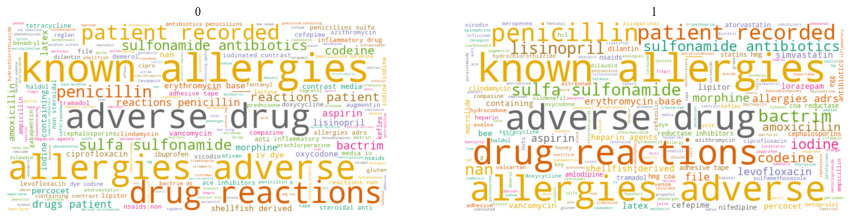

In [19]:
data = df7.copy()

# Group the data by label and concatenate the text data for each group
groups = data.groupby('hospital_expire_flag')['English'].apply(lambda x: ' '.join(str(i) for i in x))

# Generate a word cloud for each group
wordclouds = []
for group_name, group_data in groups.items():   # groups.items(): output keys and values in same time.
    # Create a word cloud object and generate the word cloud
    wc = WordCloud(width=800, height=400, background_color='white', colormap='Dark2',random_state=2023).generate(group_data)
    wordclouds.append((group_name, wc))

# Plot the word clouds
fig, axs = plt.subplots(1, len(wordclouds), figsize=(15, 10))
for i, (group_name, wc) in enumerate(wordclouds):
    axs[i].imshow(wc, interpolation='bilinear')
    axs[i].set_title(group_name)
    axs[i].axis('off')

plt.show()

In [20]:
########### dataset 7 ########
df8 = df0.copy()
df8 = df8[["Family History","hospital_expire_flag"]]
df8 = df8.applymap(lambda x: x.lower() if isinstance(x, str) else x)
df8 = df8.loc[df2.index]   # 保持和df2相同的行
df8['hospital_expire_flag'] = df8['hospital_expire_flag'].astype(np.int16)
df8.rename(columns={'Family History':'English'},inplace=True)

df_train_family, df_test_family = train_test_split(df8, test_size=0.2, random_state=seed, stratify=df8['hospital_expire_flag'])
df_train_family

,English,hospital_expire_flag
918,- sister had ___ lymphoma - mother died during...,0
1754,not known,0
3831,non-contributory,0
3261,none,0
1543,adopted,0
...,...,...
5589,father died of lung ca. grandmother died of co...,0
3700,mother w bipolar disorder and schizophrenia.,0
2647,mother:deceased father:deceased of cancer (unk...,0
4068,no known neurological disorders,0


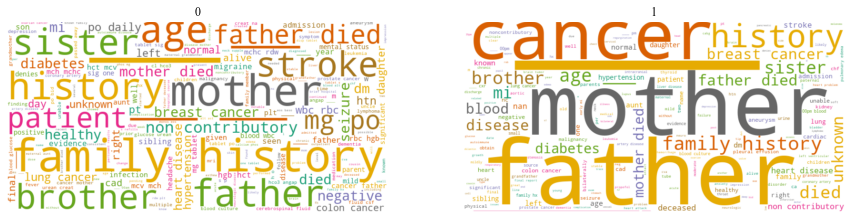

In [21]:
data = df8.copy()

# Group the data by label and concatenate the text data for each group
groups = data.groupby('hospital_expire_flag')['English'].apply(lambda x: ' '.join(str(i) for i in x))

# Generate a word cloud for each group
wordclouds = []
for group_name, group_data in groups.items():   # groups.items(): output keys and values in same time.
    # Create a word cloud object and generate the word cloud
    wc = WordCloud(width=800, height=400, background_color='white', colormap='Dark2',random_state=2023).generate(group_data)
    wordclouds.append((group_name, wc))

# Plot the word clouds
fig, axs = plt.subplots(1, len(wordclouds), figsize=(15, 10))
for i, (group_name, wc) in enumerate(wordclouds):
    axs[i].imshow(wc, interpolation='bilinear')
    axs[i].set_title(group_name)
    axs[i].axis('off')

plt.show()

In [22]:
# Load BioBERT tokenizer and model
pretrained_model = 'G:/BertModels/BioBERT'
tokenizer = AutoTokenizer.from_pretrained(pretrained_model)

In [23]:
def text2vec(df_text, col, token_length):
    #col = "Chief Complaint"
    sentences_maxlength = 1398   # 最极限的情况下，就是每个字符为一个token
    sentences = df_text[col].fillna("").values.tolist()
    encoding = tokenizer(sentences, 
                         add_special_tokens=False, 
                         return_tensors='tf', 
                         padding='max_length', 
                         truncation=True, 
                         max_length=sentences_maxlength)

    input_ids = encoding['input_ids']
    input_ids1 = input_ids.numpy()
    
#     ICD:34, ChiefComplaint:20
    input_ids1_cumF95 = input_ids1[:,:token_length]
    
    return input_ids1_cumF95

In [24]:
# Change the data form, then merge them

#################### training set
X_train0 = text2vec(df_train_chief, 'English', 20)
X_train1 = df_train_structured.iloc[:,:-1].values
# 对structured data进行tandardScaler normalization
scaler = StandardScaler()
X_train1 = scaler.fit_transform(X_train1)
X_train2 = text2vec(df_train_icd, 'English', 379)
X_train3 = text2vec(df_train_ill, 'English', 887)
X_train4 = text2vec(df_train_medical, 'English', 533)
X_train5 = text2vec(df_train_Allergies, 'English', 26)
X_train6 = text2vec(df_train_family, 'English', 75)

X_train = np.concatenate([X_train0,X_train1,X_train2,X_train3,X_train4,X_train5,X_train6], axis=1)
y_train = df_train_chief['hospital_expire_flag'].values

#################### testing set
X_test0 = text2vec(df_test_chief, 'English', 20)
X_test1 = df_test_structured.iloc[:,:-1].values
# 对structured data进行tandardScaler normalization
X_test1 = scaler.transform(X_test1)
X_test2 = text2vec(df_test_icd, 'English', 379)
X_test3 = text2vec(df_test_ill, 'English', 887)
X_test4 = text2vec(df_test_medical, 'English', 533)
X_test5 = text2vec(df_test_Allergies, 'English', 26)
X_test6 = text2vec(df_test_family, 'English', 75)

X_test = np.concatenate([X_test0,X_test1,X_test2,X_test3,X_test4,X_test5,X_test6], axis=1)
y_test = df_test_chief['hospital_expire_flag'].values

print(X_train.shape,X_test.shape)
X_train

(4636, 1943) (1159, 1943)


array([[16320.,   117.,   183., ...,     0.,     0.,     0.],
       [ 1166., 12847.,  1162., ...,     0.,     0.,     0.],
       [  172.,  9014., 23033., ...,     0.,     0.,     0.],
       ...,
       [  177.,  1183., 11439., ...,  1884.,  4934.,   117.],
       [16320.,   117., 14078., ...,     0.,     0.,     0.],
       [ 8599.,  4910.,  2781., ...,     0.,     0.,     0.]])

In [25]:
# 自定义权重
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Training

In [26]:
# FCN
max_features = 28996+1  # 词汇表大小
embed_dim = 128       # 嵌入维度
n_cols_text = 20      # 文本数据列数
n_cols_numeric = 23   # 数值数据列数
n_cols_icd = 379
n_cols_ill = 887
n_cols_medical = 533
n_cols_Allergies = 26
n_cols_family = 75

def build_model():
    # 文本输入分支
    text_input = Input(shape=(n_cols_text,), dtype='int32')
    text_embedding = Embedding(input_dim=max_features, output_dim=embed_dim, input_length=n_cols_text)(text_input)
    text_flatten = Flatten()(text_embedding)

    # 数值输入分支
    numeric_input = Input(shape=(n_cols_numeric,))
    numeric_dense = Dense(128, activation='relu')(numeric_input)

    # icd输入分支
    icd_input = Input(shape=(n_cols_icd,), dtype='int32')
    icd_embedding = Embedding(input_dim=max_features, output_dim=embed_dim, input_length=n_cols_icd)(icd_input)
    icd_flatten = Flatten()(icd_embedding)

    # ill输入分支
    ill_input = Input(shape=(n_cols_ill,), dtype='int32')
    ill_embedding = Embedding(input_dim=max_features, output_dim=embed_dim, input_length=n_cols_ill)(ill_input)
    ill_flatten = Flatten()(ill_embedding)

    # medical输入分支
    medical_input = Input(shape=(n_cols_medical,), dtype='int32')
    medical_embedding = Embedding(input_dim=max_features, output_dim=embed_dim, input_length=n_cols_medical)(medical_input)
    medical_flatten = Flatten()(medical_embedding)

    # Allergies输入分支
    Allergies_input = Input(shape=(n_cols_Allergies,), dtype='int32')
    Allergies_embedding = Embedding(input_dim=max_features, output_dim=embed_dim, input_length=n_cols_Allergies)(Allergies_input)
    Allergies_flatten = Flatten()(Allergies_embedding)

    # family输入分支
    family_input = Input(shape=(n_cols_family,), dtype='int32')
    family_embedding = Embedding(input_dim=max_features, output_dim=embed_dim, input_length=n_cols_family)(family_input)
    family_flatten = Flatten()(family_embedding)

    # 合并七个分支
    merged = concatenate([text_flatten, numeric_dense, icd_flatten, ill_flatten, medical_flatten, Allergies_flatten, family_flatten])

    # 后续层
    merged_dense = Dense(128, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), activation='relu')(merged)
    merged_dropout = Dropout(0.5)(merged_dense)
    output = Dense(2, activation='softmax')(merged_dropout)

    # 构建模型
    model = Model(inputs=[text_input, numeric_input, icd_input, ill_input, medical_input, Allergies_input, family_input], outputs=output)

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [55]:
# CNN
max_features = 28996+1  # 词汇表大小
embed_dim = 128       # 嵌入维度
n_cols_text = 20      # 文本数据列数
n_cols_numeric = 23   # 数值数据列数
n_cols_icd = 379    # ICD文本数据
n_cols_ill = 887    # ill文本数据
n_cols_medical = 533   # 用药史
n_cols_Allergies = 26
n_cols_family = 75

def build_model():
    # 文本输入分支
    text_input = Input(shape=(n_cols_text,), dtype='int32')
    text_embedding = Embedding(input_dim=max_features, output_dim=embed_dim, input_length=n_cols_text)(text_input)

    # 数值输入分支
    numeric_input = Input(shape=(n_cols_numeric,))
    numeric_dense = Dense(128, activation='relu')(numeric_input)
    # Reshape numeric input to have a temporal dimension
    numeric_reshaped = Reshape((1, -1))(numeric_dense)  # Reshape to shape (batch_size, 1, n_cols_numeric)

    # icd输入分支
    icd_input = Input(shape=(n_cols_icd,), dtype='int32')
    icd_embedding = Embedding(input_dim=max_features, output_dim=embed_dim, input_length=n_cols_icd)(icd_input)

    # ill输入分支
    ill_input = Input(shape=(n_cols_ill,), dtype='int32')
    ill_embedding = Embedding(input_dim=max_features, output_dim=embed_dim, input_length=n_cols_ill)(ill_input)

    # medical输入分支
    medical_input = Input(shape=(n_cols_medical,), dtype='int32')
    medical_embedding = Embedding(input_dim=max_features, output_dim=embed_dim, input_length=n_cols_medical)(medical_input)

    # Allergies输入分支
    Allergies_input = Input(shape=(n_cols_Allergies,), dtype='int32')
    Allergies_embedding = Embedding(input_dim=max_features, output_dim=embed_dim, input_length=n_cols_Allergies)(Allergies_input)

    # family输入分支
    family_input = Input(shape=(n_cols_family,), dtype='int32')
    family_embedding = Embedding(input_dim=max_features, output_dim=embed_dim, input_length=n_cols_family)(family_input)

    # 合并七个分支
    merged = concatenate([text_embedding, numeric_reshaped, icd_embedding, ill_embedding, medical_embedding, Allergies_embedding, family_embedding], axis=1)   # Concatenate along the time axis

    # 后续层
    merged_dense = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(merged)
    merged_pool = AveragePooling1D(pool_size=2)(merged_dense)

    merged_flat = Flatten()(merged_pool)  # Flatten the output for the Dense layer
    merged_dropout = Dropout(0.5)(merged_flat)
#     merged_dropout = Dense(128, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), activation='relu')(merged_dropout)
#     merged_dropout = Dropout(0.5)(merged_dropout)
    output = Dense(2, activation='softmax')(merged_dropout)

    # 构建模型
    model = Model(inputs=[text_input, numeric_input, icd_input, ill_input, medical_input, Allergies_input, family_input], outputs=output)

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [28]:
# LSTM
max_features = 28996+1  # 词汇表大小
embed_dim = 128       # 嵌入维度
lstm_out = 128
n_cols_text = 20      # 文本数据列数
n_cols_numeric = 23   # 数值数据列数
n_cols_icd = 379    # ICD文本数据
n_cols_ill = 887    # ill文本数据
n_cols_medical = 533   # 用药史
n_cols_Allergies = 26
n_cols_family = 75

def build_model():
    # 文本输入分支
    text_input = Input(shape=(n_cols_text,), dtype='int32')
    text_embedding = Embedding(input_dim=max_features, output_dim=embed_dim, input_length=n_cols_text)(text_input)
    lstm_output_text = LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.0)(text_embedding)

    # 数值输入分支
    numeric_input = Input(shape=(n_cols_numeric,))
    numeric_dense = Dense(128, activation='relu')(numeric_input)

    # icd输入分支
    icd_input = Input(shape=(n_cols_icd,), dtype='int32')
    icd_embedding = Embedding(input_dim=max_features, output_dim=embed_dim, input_length=n_cols_icd)(icd_input)
    lstm_output_icd = LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.0)(icd_embedding)

    # ill输入分支
    ill_input = Input(shape=(n_cols_ill,), dtype='int32')
    ill_embedding = Embedding(input_dim=max_features, output_dim=embed_dim, input_length=n_cols_ill)(ill_input)
    lstm_output_ill = LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.0)(ill_embedding)

    # medical输入分支
    medical_input = Input(shape=(n_cols_medical,), dtype='int32')
    medical_embedding = Embedding(input_dim=max_features, output_dim=embed_dim, input_length=n_cols_medical)(medical_input)
    lstm_output_medical = LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.0)(medical_embedding)

    # Allergies输入分支
    Allergies_input = Input(shape=(n_cols_Allergies,), dtype='int32')
    Allergies_embedding = Embedding(input_dim=max_features, output_dim=embed_dim, input_length=n_cols_Allergies)(Allergies_input)
    lstm_output_Allergies = LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.0)(Allergies_embedding)

    # family输入分支
    family_input = Input(shape=(n_cols_family,), dtype='int32')
    family_embedding = Embedding(input_dim=max_features, output_dim=embed_dim, input_length=n_cols_family)(family_input)
    lstm_output_family = LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.0)(family_embedding)

    # 合并七个分支
    merged = concatenate([lstm_output_text, numeric_dense, lstm_output_icd, lstm_output_ill, lstm_output_medical, lstm_output_Allergies, lstm_output_family])

    # 后续层
    merged_dense = Dense(128, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), activation='relu')(merged)
    merged_dropout = Dropout(0.5)(merged_dense)
    output = Dense(2, activation='softmax')(merged_dropout)

    # 构建模型
    model = Model(inputs=[text_input, numeric_input, icd_input, ill_input, medical_input, Allergies_input, family_input], outputs=output)

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [56]:
num_epochs = 100   # 这里的数值为20的倍数，要不然后面显示会出错
k = 4
num_val_samples = X_train.shape[0] // k
all_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = X_train[i*num_val_samples : (i+1)*num_val_samples]
    val_targets = y_train[i*num_val_samples : (i+1)*num_val_samples]
    val_data_text = val_data[:,:20]
    val_data_numeric = val_data[:,20:20+23]
    val_data_icd = val_data[:,20+23:20+23+379]
    val_data_ill = val_data[:,20+23+379:20+23+379+887]
    val_data_medical = val_data[:,20+23+379+887:20+23+379+887+533]
    val_data_Allergies = val_data[:,20+23+379+887+533:20+23+379+887+533+26]
    val_data_family = val_data[:,20+23+379+887+533+26:]
    
    partial_train_data = np.concatenate([X_train[:i * num_val_samples], X_train[(i+1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([y_train[:i * num_val_samples], y_train[(i+1) * num_val_samples:]], axis=0)
    partial_train_data_text = partial_train_data[:,:20]
    partial_train_data_numeric = partial_train_data[:,20:20+23]
    partial_train_data_icd = partial_train_data[:,20+23:20+23+379]
    partial_train_data_ill = partial_train_data[:,20+23+379:20+23+379+887]
    partial_train_data_medical = partial_train_data[:,20+23+379+887:20+23+379+887+533]
    partial_train_data_Allergies = partial_train_data[:,20+23+379+887+533:20+23+379+887+533+26]
    partial_train_data_family = partial_train_data[:,20+23+379+887+533+26:]
    
    model = build_model()
    history = model.fit([partial_train_data_text,
                         partial_train_data_numeric,
                         partial_train_data_icd,
                        partial_train_data_ill,
                        partial_train_data_medical,
                        partial_train_data_Allergies,
                        partial_train_data_family],partial_train_targets,
                        validation_data = ([val_data_text,
                                            val_data_numeric,
                                            val_data_icd,
                                           val_data_ill,
                                           val_data_medical,
                                           val_data_Allergies,
                                           val_data_family], val_targets),
                       epochs = num_epochs, batch_size = 64, verbose = 0, class_weight=class_weights)
    all_histories.append(history.history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [57]:
average_loss = [np.mean([x['loss'][i] for x in all_histories]) for i in range(num_epochs)]
average_accuracy = [np.mean([x['accuracy'][i] for x in all_histories]) for i in range(num_epochs)]

average_val_loss = [np.mean([x['val_loss'][i] for x in all_histories]) for i in range(num_epochs)]
average_val_accuracy = [np.mean([x['val_accuracy'][i] for x in all_histories]) for i in range(num_epochs)]

In [58]:
# 间隔20个点标注一个，展示20个点的平均数
gap = 1
n = int(num_epochs/gap)    # 要标记点的个数

loss_gap10 = [np.average(average_loss[gap*i:gap*(i+1)]) for i in range(n)]
acc_gap10 = [np.average(average_accuracy[gap*i:gap*(i+1)]) for i in range(n)]

val_loss_gap10 = [np.average(average_val_loss[gap*i:gap*(i+1)]) for i in range(n)]
val_acc_gap10 = [np.average(average_val_accuracy[gap*i:gap*(i+1)]) for i in range(n)]

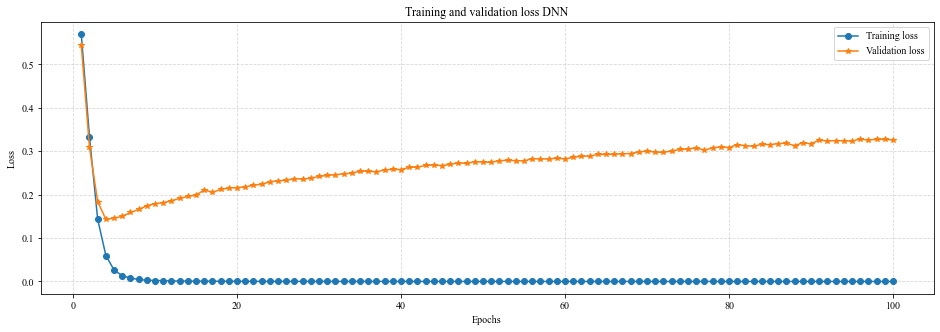

In [59]:
epochs = [each*gap for each in range(1, 1+n)]

plt.figure(figsize = (16,5))
plt.clf() 
plt.plot(epochs, loss_gap10, 'o-', label='Training loss')
plt.plot(epochs, val_loss_gap10, '*-', label='Validation loss')
plt.title('Training and validation loss DNN')
plt.grid(True, linestyle="--", alpha=0.5)  # 添加网格线
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 保存高清图像
# plt.savefig('./image/DNN_loss_standardization.jpg', dpi=300, bbox_inches='tight')
# plt.tight_layout()

plt.show()

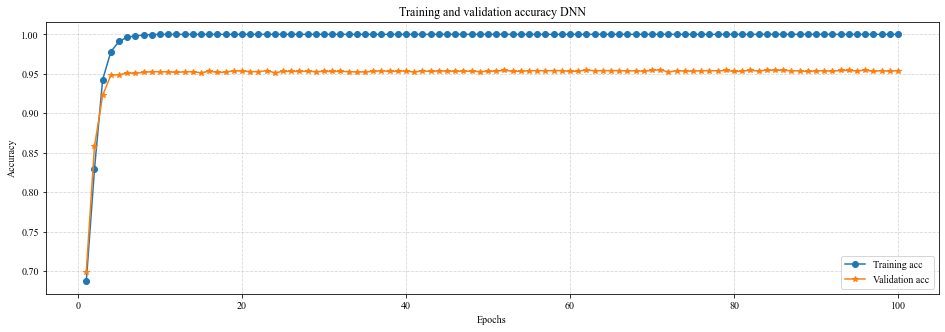

In [60]:
plt.figure(figsize = (16,5))
# plt.grid(axis="y")
plt.plot(epochs, acc_gap10, 'o-', label='Training acc')
plt.plot(epochs, val_acc_gap10, '*-', label='Validation acc')
plt.title('Training and validation accuracy DNN')
plt.grid(True, linestyle="--", alpha=0.5)  # 添加网格线
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 保存高清图像
# plt.savefig('./image/DNN_accuracy_standardization.jpg', dpi=300, bbox_inches='tight')
# plt.tight_layout()

plt.show()

In [124]:
model = build_model()
model.fit([X_train[:,:20],
           X_train[:,20:20+23],
           X_train[:,20+23:20+23+379],
           X_train[:,20+23+379:20+23+379+887],
           X_train[:,20+23+379+887:20+23+379+887+533],
          X_train[:,20+23+379+887+533:20+23+379+887+533+26],
          X_train[:,20+23+379+887+533+26:]], y_train, epochs = 4, batch_size = 64, verbose = 1, class_weight=class_weights)

Epoch 1/4
73/73 [==============================] - 3s 29ms/step - loss: 0.5454 - accuracy: 0.7045
Epoch 2/4
73/73 [==============================] - 2s 29ms/step - loss: 0.3062 - accuracy: 0.8479
Epoch 3/4
73/73 [==============================] - 2s 29ms/step - loss: 0.1162 - accuracy: 0.9551
Epoch 4/4
73/73 [==============================] - 2s 29ms/step - loss: 0.0503 - accuracy: 0.9786


In [125]:
# save model
# model.save('E:/CNSI_project/demo_and_data_4.0/models/Aim2/Aim2_ChiefComplaint.h5')

In [43]:
# load model
from tensorflow.keras.models import load_model
# model = load_model('E:/CNSI_project/demo_and_data_5.0/models_v2.1/aim2_selected/Aim2_ChiefStructuredICDillMedicalAllergiesFamily_FCN.h5')
# model = load_model('E:/CNSI_project/demo_and_data_5.0/models_v2.2/Aim2_ChiefStructuredICDillMedicalAllergiesFamily_CNN.h5')
model = load_model('E:/CNSI_project/demo_and_data_5.0/models_v2.1/aim2_selected/Aim2_ChiefStructuredICDillMedicalAllergiesFamily_LSTM.h5')

# Testing

In [44]:
X_test_text = X_test[:,:20]
X_test_numeric = X_test[:,20:20+23]
X_test_icd = X_test[:,20+23:20+23+379]
X_test_ill = X_test[:,20+23+379:20+23+379+887]
X_test_medical = X_test[:,20+23+379+887:20+23+379+887+533]
X_test_Allergies = X_test[:,20+23+379+887+533:20+23+379+887+533+26]
X_test_family = X_test[:,20+23+379+887+533+26:]
y_test

array([0, 0, 0, ..., 0, 1, 0], dtype=int16)

In [45]:
score,acc = model.evaluate([X_test_text,X_test_numeric,X_test_icd,X_test_ill,X_test_medical,X_test_Allergies,X_test_family], y_test, verbose = 2)
print("score: %.3f" % (score))
print("acc: %.3f" % (acc))

37/37 - 13s - loss: 0.4961 - accuracy: 0.8076 - 13s/epoch - 353ms/step
score: 0.496
acc: 0.808


In [46]:
predict_test = model.predict([X_test_text,X_test_numeric,X_test_icd,X_test_ill,X_test_medical,X_test_Allergies,X_test_family])
predict_test

37/37 [==============================] - 3s 47ms/step


array([[0.8206398 , 0.17936015],
       [0.97356725, 0.02643276],
       [0.9897323 , 0.01026769],
       ...,
       [0.99298507, 0.00701486],
       [0.14318694, 0.8568131 ],
       [0.83149004, 0.1685099 ]], dtype=float32)

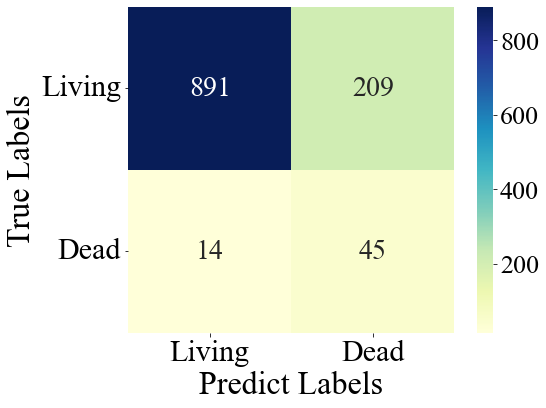

In [47]:
# generate confusion matrix
labels1 = ["Living", "Dead"]
plt.figure(figsize = (8, 6))
cm = confusion_matrix(y_test, np.argmax(predict_test,axis=1))
ax = sns.heatmap(cm, square=True, annot=True , cmap="YlGnBu", annot_kws={"fontsize":28}, fmt=".0f")   #square=True, annot=True showing number
# plt.matshow(cm)
# plt.title('Confusion matrix DNN', fontsize=18)
plt.ylabel("True Labels", fontsize=32)
plt.xlabel("Predict Labels", fontsize=32)

# 设置colorbar字体
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=26)

# plt.colorbar()
plt.xticks([i + 0.5 for i in range(len(labels1))], labels1, rotation = 0, fontsize=30)
plt.yticks([i + 0.5 for i in range(len(labels1))], labels1, rotation = 0, fontsize=30)

# 保存高清图像
# plt.savefig('./image/Confusion_matrix_standardization_dnn1.jpg', dpi=300, bbox_inches='tight')
# plt.tight_layout()

plt.show()

In [48]:
cm

array([[891, 209],
       [ 14,  45]], dtype=int64)

In [49]:
predict_matrix = np.zeros(cm.shape)
for i in range(cm.shape[0]):
    temp = np.sum(cm[i])
    for j in range(cm.shape[1]):
        predict_matrix[i,j] = cm[i,j]/temp
predict_matrix

array([[0.81      , 0.19      ],
       [0.23728814, 0.76271186]])

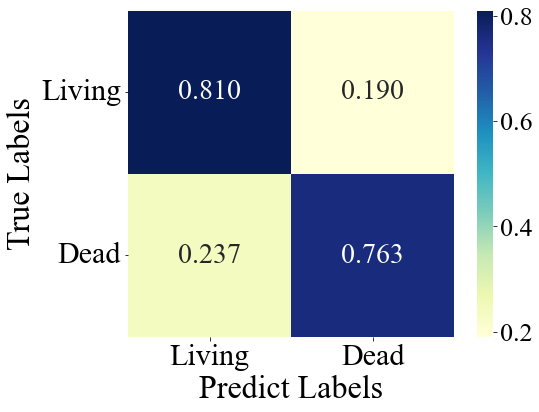

In [50]:
plt.figure(figsize = (8, 6))
ax = sns.heatmap(predict_matrix, square=True, annot=True ,cmap="YlGnBu", annot_kws={"fontsize":28}, fmt=".3f")
plt.xticks([i + 0.5 for i in range(len(predict_matrix))], labels1, rotation = 0, fontsize=30)
plt.yticks([i + 0.5 for i in range(len(predict_matrix))], labels1, rotation = 0, fontsize=30)

# 设置colorbar字体
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=26)

# plt.title('Confusion matrix of prediction', fontsize=18)
plt.ylabel("True Labels", fontsize=32)
plt.xlabel("Predict Labels", fontsize=32)

# 保存高清图像
# plt.savefig('./image/Confusion_matrix_standardization_dnn2.jpg', dpi=300, bbox_inches='tight')
# plt.tight_layout()

plt.show()

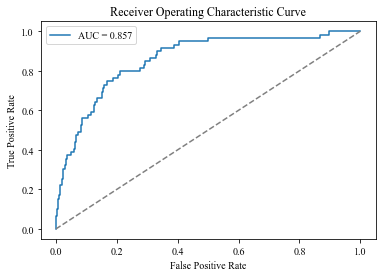

In [51]:
# Calculate AUC score and plot ROC curve
auc = roc_auc_score(y_test, predict_test[:,1])
fpr, tpr, thresholds = roc_curve(y_test, predict_test[:,1])

plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()

In [36]:
# NN1
y_test_all_nn1 = y_test.copy()
y_predict_all_nn1 = predict_test.copy()

# 将imputer保存为pickle文件，便于后面调用。
with open("E:/CNSI_project/demo_and_data_5.0/Processed_data/AUCpickle/NN1_all.pickle","wb") as f:
    pickle.dump([y_test_all_nn1,y_predict_all_nn1], f)

In [41]:
# NN2
y_test_all_nn2 = y_test.copy()
y_predict_all_nn2 = predict_test.copy()

# 将imputer保存为pickle文件，便于后面调用。
with open("E:/CNSI_project/demo_and_data_5.0/Processed_data/AUCpickle/NN2_all.pickle","wb") as f:
    pickle.dump([y_test_all_nn2,y_predict_all_nn2], f)

In [66]:
# NN3
y_test_all_nn3 = y_test.copy()
y_predict_all_nn3 = predict_test.copy()

# 将imputer保存为pickle文件，便于后面调用。
with open("E:/CNSI_project/demo_and_data_5.0/Processed_data/AUCpickle/NN3_all.pickle","wb") as f:
    pickle.dump([y_test_all_nn3,y_predict_all_nn3], f)

In [35]:
# calculate evaluation metric using test cohort
accuracy0 = np.round(accuracy_score(y_test, 
               np.argmax(predict_test,axis=1)), decimals = 3)
print('\n1dCNN Predictive Accuracy: ',accuracy0)


1dCNN Predictive Accuracy:  0.85


In [36]:
print('\nSummary of 1dCNN Precision and Recall\n') 
print(classification_report(y_test, np.argmax(predict_test,axis=1), 
                            target_names = labels1, digits=3))


Summary of 1dCNN Precision and Recall

              precision    recall  f1-score   support

      Living      0.990     0.850     0.915      1100
        Dead      0.233     0.847     0.365        59

    accuracy                          0.850      1159
   macro avg      0.612     0.849     0.640      1159
weighted avg      0.952     0.850     0.887      1159



In [37]:
2*(0.198*0.814)/(0.198+0.814)

0.3185217391304348

In [39]:
y_true = np.array(y_test).flatten()  # 将 y_test 转化为一维数组
y_true = y_true.astype(int)  # 将 y_test 转化为整数数组
y_pred = predict_test.argmax(axis=1)

cm = confusion_matrix(y_true, y_pred)
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 

# The weights for each class
weights = np.bincount(y_true) / len(y_true)

# Weighted average sensitivity and specificity
weighted_avg_sensitivity = np.sum(weights * np.array([TPR, TNR]))
weighted_avg_specificity = np.sum(weights * np.array([TNR, TPR]))

print('Weighted avg sensitivity:', weighted_avg_sensitivity)
print('Weighted avg specificity:', weighted_avg_specificity)

Weighted avg sensitivity: 0.8475407708946264
Weighted avg specificity: 0.8490077653149267


# AUPRC、C-index 和 Brier Score

FCN AUPRC: 0.466
Baseline (positive class ratio): 0.051


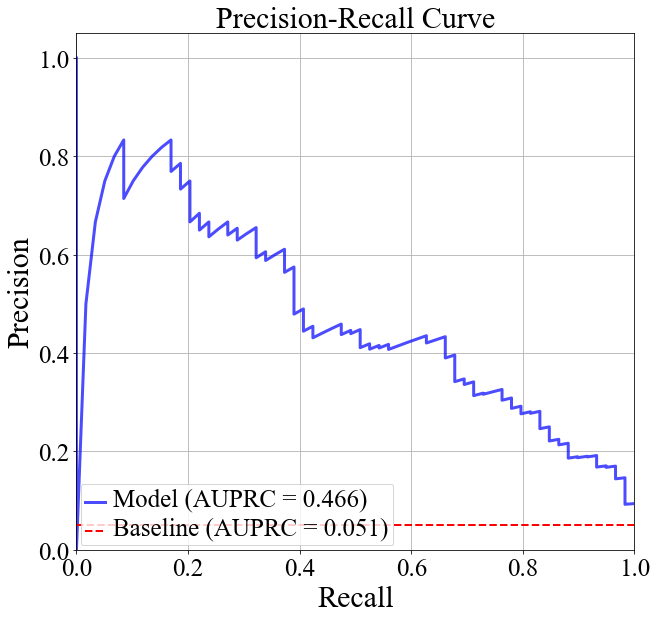

In [38]:
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, brier_score_loss
from lifelines.utils import concordance_index

# AUPRC
precision, recall, _ = precision_recall_curve(y_test, predict_test[:, 1])
auprc = auc(recall, precision)
print(f'FCN AUPRC: {auprc:.3f}')

# 计算基线值（正样本比例）
baseline = sum(y_test) / len(y_test)
print(f'Baseline (positive class ratio): {baseline:.3f}')

# 绘制 AUPRC 曲线
plt.figure(figsize=(10, 9.5))
plt.plot(recall, precision, color='blue', label=f'Model (AUPRC = {auprc:.3f})', linewidth=3, alpha=0.7)

# 添加基线水平线
plt.axhline(y=baseline, color='red', linestyle='--', label=f'Baseline (AUPRC = {baseline:.3f})', linewidth=2)

# 设置标签和标题
plt.xlabel('Recall', fontsize=30, fontname='Times New Roman')  # 召回率
plt.ylabel('Precision', fontsize=30, fontname='Times New Roman')  # 精确度
plt.title('Precision-Recall Curve', fontsize=30, fontname='Times New Roman')

# 添加图例并设置字体
legend = plt.legend(loc='lower left')
for text in legend.get_texts():
    text.set_fontname('Times New Roman')
    text.set_fontsize(25)

plt.grid()

# 美化图形
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=25, fontname='Times New Roman')
plt.yticks(fontsize=25, fontname='Times New Roman')

# 显示图形
plt.show()


In [39]:
# C-index
# C-index 常用于生存分析，但也可以用于分类任务来衡量模型对生存或事件排序的一致性。
# 对于二分类任务，可以简单地使用 lifelines.utils 中的 concordance_index 函数。
c_index = concordance_index(y_test, predict_test[:,1])
print(f'FCN C-index: {c_index:.3f}')

FCN C-index: 0.932


In [40]:
# Brier Score 
# 衡量模型预测概率与实际结果之间的均方误差。
brier_score = brier_score_loss(y_test, predict_test[:,1])
print(f'FCN Brier Score: {brier_score:.3f}')

FCN Brier Score: 0.105
